In [306]:
import geopandas
import fiona
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [307]:

# load LA neighborhood geo data
geojson_file_loc = "data/mapping-la-data-main/geojson/la-county-neighborhoods-v6.geojson"
geo_la_neighborhood = geopandas.read_file(geojson_file_loc)
# LA EPSG transformation
geo_la_neighborhood = geo_la_neighborhood.to_crs(3310)
geo_la_neighborhood["area"] = geo_la_neighborhood.area/2.59e+6
geo_la_neighborhood = geo_la_neighborhood.to_crs(4326)
geo_la_neighborhood['boundary'] = geo_la_neighborhood.boundary
geo_la_neighborhood['centroid'] = geo_la_neighborhood.centroid

# load LA neighborhood poplulation data
pop_la_neighborhood = pd.read_csv('data/la-neighborhood-population.csv')
# merge two dataframe together
df = geo_la_neighborhood.merge(pop_la_neighborhood, left_on='name', right_on='Neighborhood', how='inner')
del df['Neighborhood']
del df['kind']
del df['external_id']
del df['slug']
del df['set']
del df['metadata']
del df['resource_uri']
df = df.rename(columns={'Population per Sqmi':'pop_density'})
df['pop'] = round(df['pop_density'] * df['area'])

C:\Users\guanc\AppData\Local\Temp\ipykernel_26856\1998086962.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  geo_la_neighborhood['centroid'] = geo_la_neighborhood.centroid


In [308]:
# load LA existing vertiport data
df_heliport = pd.read_csv('data/us-heliports-landing-facilities.csv')
del df_heliport['State_Name']
del df_heliport['Facility_Type']
del df_heliport['County_s_State_Post_Office_Code']
df_airport = pd.read_csv('data/us-general-aviation-airports.csv')
del df_airport['County_s_State_Post_Office_Code']
del df_airport['State_Name']
df_vertiport = pd.concat([df_heliport, df_airport])
mask = (df_vertiport['SHAPE_X'] <-117.6) & (df_vertiport['SHAPE_X'] > -119) & (df_vertiport['SHAPE_Y'] <34.8) & (df_vertiport['SHAPE_Y'] > 33.6)
df_vertiport_la = df_vertiport[mask]

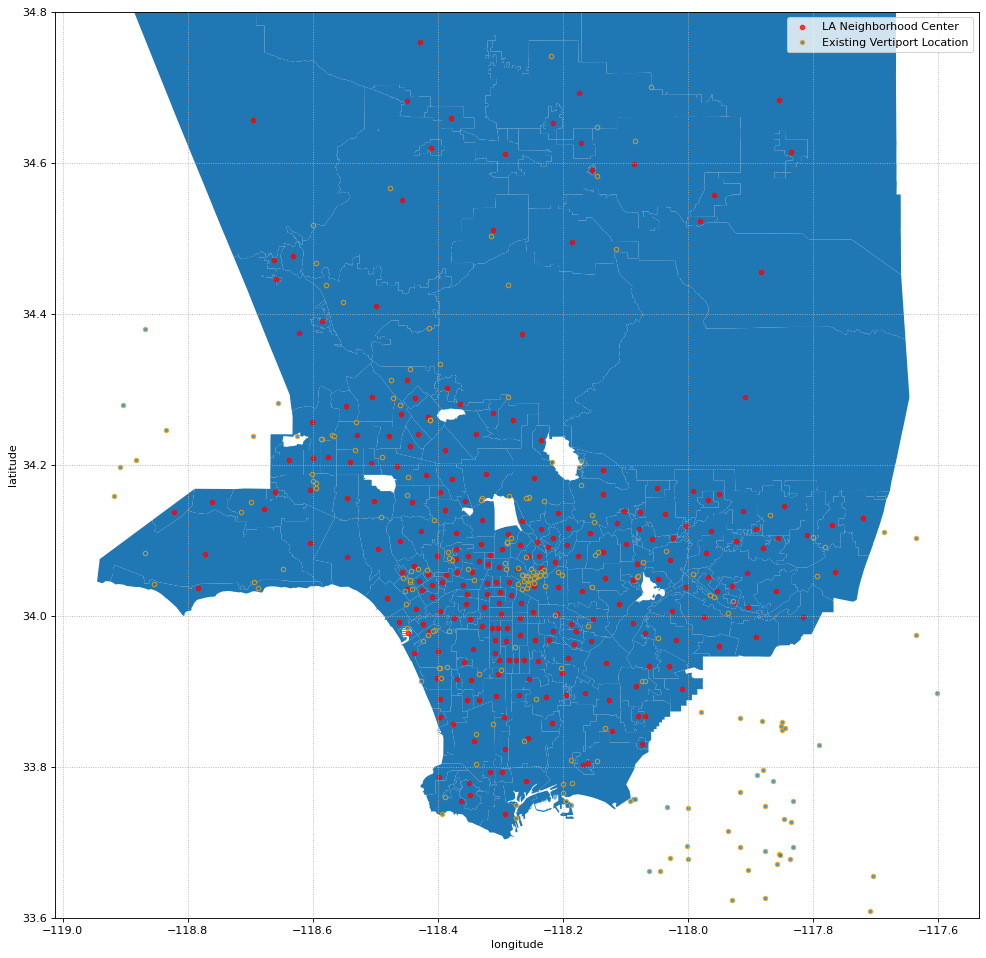

In [309]:

fig, ax = plt.subplots(figsize=(15,15), dpi=80)
df.plot(ax=ax, label='LA Neighborhood')
c = geopandas.GeoDataFrame(df, geometry=df['centroid'], crs='EPSG:4326')
c.plot(ax=ax, color='red',alpha=0.75, markersize=16, label='LA Neighborhood Center')
ax.scatter(df_vertiport_la['SHAPE_X'], df_vertiport_la['SHAPE_Y'], s=16, edgecolors='orange', alpha=0.75, label='Existing Vertiport Location')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_ylim(33.6, 34.8)
ax.legend()
ax.grid(linestyle=':')
plt.savefig('proj01.png')

In [310]:
from scipy.sparse import csr_matrix
df_centroid = pd.DataFrame(df[['name','centroid','pop']])
n = len(df_centroid)
df_centroid['idx'] = df_centroid.index
# Cartesian product to calculate distance between all centroid pairs
centroid_pair = df_centroid.merge(df_centroid, how='cross')
gs_centroid_pair = geopandas.GeoDataFrame(centroid_pair, geometry=centroid_pair['centroid_x'], crs='EPSG:3310')
gs_centroid_pair['distance']=gs_centroid_pair.apply(lambda x: x['centroid_x'].distance(x['centroid_y']), axis=1)
gs_centroid_pair['total_pop']=gs_centroid_pair.apply(lambda x: x['pop_x'] + x['pop_y'], axis=1)
# distance matrix
D = csr_matrix((gs_centroid_pair['distance'], (gs_centroid_pair['idx_x'], gs_centroid_pair['idx_y'])), shape=(n,n))
# population matrix
P = csr_matrix((gs_centroid_pair['total_pop'], (gs_centroid_pair['idx_x'], gs_centroid_pair['idx_y'])), shape=(n,n))
P = P / np.max(P)


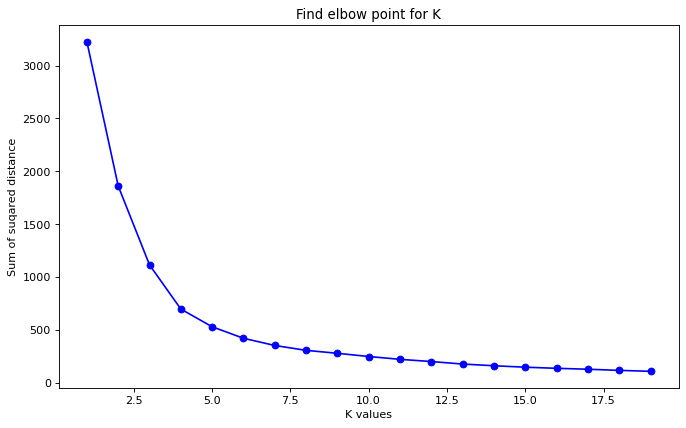

In [311]:
from sklearn.manifold import Isomap
from sklearn.cluster import KMeans
embedding = Isomap(n_neighbors=10,n_components=2)
D_transformed = embedding.fit_transform(D)

sum_of_squared_distiance=[]
K = range(1,20)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(D_transformed)
    sum_of_squared_distiance.append(kmeans.inertia_)
fig, ax = plt.subplots(1,1,figsize=(10,6), dpi=80)
ax.plot(K,sum_of_squared_distiance,'bo-')
ax.set_xlabel('K values')
ax.set_ylabel('Sum of suqared distance')
ax.set_title('Find elbow point for K')
plt.savefig('proj02.png')

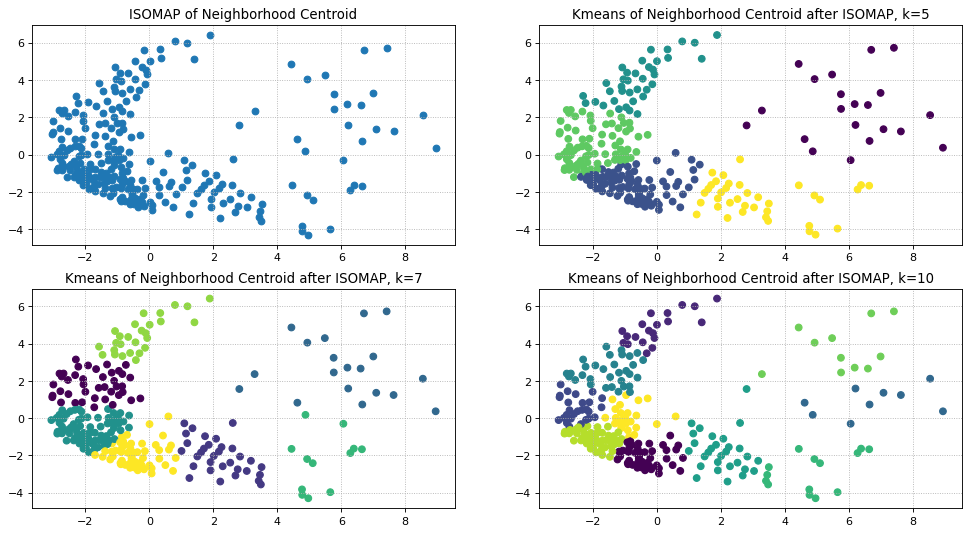

In [312]:


fig, ax = plt.subplots(2,2,figsize=(15,8), dpi=80)
ax[0,0].scatter(D_transformed[:,0], D_transformed[:,1])
ax[0,0].set_title('ISOMAP of Neighborhood Centroid')
ax[0,0].grid(linestyle=':')

kmeans_5 = KMeans(n_clusters=5, random_state=0).fit(D_transformed)
kmeans_7 = KMeans(n_clusters=7, random_state=0).fit(D_transformed)
kmeans_10 = KMeans(n_clusters=10, random_state=0).fit(D_transformed)
ax[0,1].scatter(D_transformed[:,0], D_transformed[:,1], c=kmeans_5.labels_)
ax[0,1].set_title('Kmeans of Neighborhood Centroid after ISOMAP, k=5')
ax[0,1].grid(linestyle=':')
ax[1,0].scatter(D_transformed[:,0], D_transformed[:,1], c=kmeans_7.labels_)
ax[1,0].set_title('Kmeans of Neighborhood Centroid after ISOMAP, k=7')
ax[1,0].grid(linestyle=':')
ax[1,1].scatter(D_transformed[:,0], D_transformed[:,1], c=kmeans_10.labels_)
ax[1,1].set_title('Kmeans of Neighborhood Centroid after ISOMAP, k=10')
ax[1,1].grid(linestyle=':')
plt.savefig('proj03.png')

C:\Users\guanc\AppData\Local\Temp\ipykernel_26856\4029914779.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_dissolve['centroid'] = df_dissolve.centroid


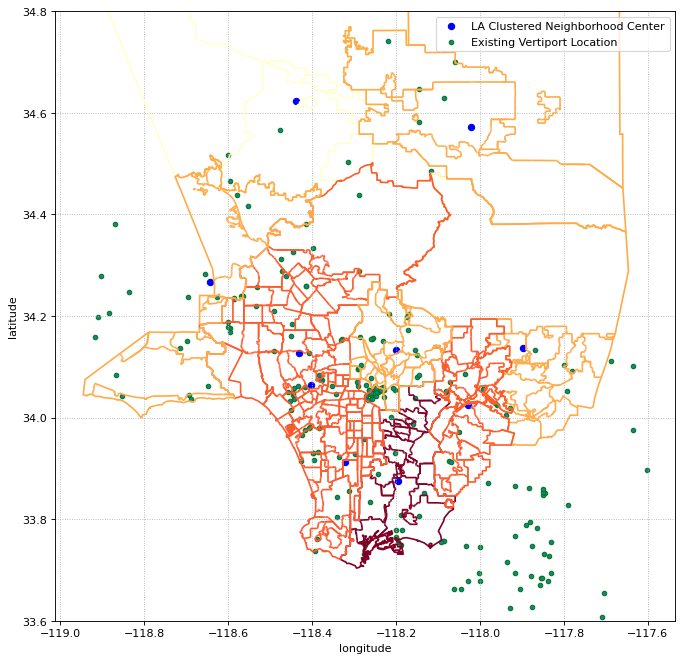

In [313]:
df['label']=kmeans_10.labels_

df_pre_dissolve = geopandas.GeoDataFrame(df, geometry=df['boundary'],crs='EPSG:4326')
df_dissolve = df[['geometry', 'pop', 'label']].dissolve(by='label', aggfunc='sum')
df_dissolve['centroid'] = df_dissolve.centroid

fig, ax = plt.subplots(figsize=(10,15), dpi=80)
df_dissolve.plot(ax=ax,column = 'pop', scheme='Percentiles', cmap='YlOrRd')
df_dissolve_c = geopandas.GeoDataFrame(df_dissolve)
df_dissolve_c['geometry'] = df_dissolve_c['centroid']
df_dissolve_c.plot(ax=ax, color='blue', markersize=32, label='LA Clustered Neighborhood Center')
ax.scatter(df_vertiport_la['SHAPE_X'], df_vertiport_la['SHAPE_Y'], s=16, edgecolors='green', label='Existing Vertiport Location')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_ylim(33.6,34.8)
ax.legend()
ax.grid(linestyle=':')
plt.savefig('proj04.png')

In [314]:
# generate optimization table

# calculate population ij, and distance ij
df_dissolve = df_dissolve.to_crs(3310)
for i in df_dissolve.index:
    df_dissolve['pop_'+ str(i)] = df_dissolve.apply(lambda x: x['pop'] + df_dissolve['pop'][i], axis=1)
    df_dissolve.loc[i, 'pop_'+ str(i)] = 0
    df_dissolve['dist_'+ str(i)] = df_dissolve.apply(lambda x: x['geometry'].distance(df_dissolve.loc[i, 'geometry'])/1609.34, axis=1)
    # set percentage of population will use eVTOL as commute 
    # total commute is 5% of population, eVTOL commute is 2.5% of total commute
    df_dissolve['eVTOL%_'+ str(i)] = 0.05 * 0.025

# assign existing vertiport label

# find which cluster center a vertiport is close to
def min_dist(x, k=10):
    dist = []
    for i in range(k):
        dist.append(x['to_center_'+str(i)])
    if min(dist) < 0.2: # threshold can be changed
        return dist.index(min(dist))
    else:
        # ignore vertiport that is far away to any cluster center
        return 10

def total_commute(x, k=10):
    # P=0.5 net profit per passenger per mile
    commute = 0
    for i in range(k):
        commute += x['pop_'+ str(i)] * x['eVTOL%_'+str(i)]
    return round(commute)


def total_prof(x, k=10, P=0.5):
    # P=0.5 net profit per passenger per mile
    prof = 0
    for i in range(k):
        prof += x['pop_'+ str(i)] * x['dist_'+ str(i)] * x['eVTOL%_'+str(i)]
    return round(prof * P)

gs_vertiport = geopandas.GeoSeries.from_wkt(df_vertiport_la['WKT'])
gdf_vertiport = geopandas.GeoDataFrame(df_vertiport_la[['WKT', 'SHAPE_X', 'SHAPE_Y']], geometry=gs_vertiport, crs="EPSG:4326")
for i in df_dissolve.index:
    gdf_vertiport['to_center_'+str(i)] = gdf_vertiport.apply(lambda x: x['geometry'].distance(df_dissolve.loc[i, 'centroid']), axis=1)
gdf_vertiport['cluster'] = gdf_vertiport.apply(min_dist, axis=1)

# df_dissolve['eVTOL%'] = 0.25
df_dissolve['existing_vertiport'] = gdf_vertiport.groupby(['cluster']).size()[:-1]
df_dissolve['total_commute'] = df_dissolve.apply(total_commute, axis=1)
df_dissolve['total_prof'] = df_dissolve.apply(total_prof, axis=1)

In [315]:
df_dissolve.to_csv('data/cluster.csv')  

In [318]:
df_dissolve.iloc[:, -3:]

,existing_vertiport,total_commute,total_prof
label,,,
0,22,23978.68625,234181.569538
1,4,19477.98625,262393.792989
2,18,29937.27625,363380.041365
3,3,12102.90625,262214.006164
4,14,23009.09625,255309.334879
5,12,23165.23625,237607.035225
6,19,15159.31625,233363.448985
7,5,14693.36625,299065.506234
8,13,29253.61625,330538.295336
